# Séance 1 :  Deep Learning - Introduction à Pytorch 

Les notebooks sont très largement inspirés des cours de **N. Baskiotis et B. Piwowarski**. Ils peuvent être complétés efficacement par les tutoriels *officiels* présents sur le site de pytorch:
https://pytorch.org/tutorials/

Au niveau de la configuration, toutes les installations doivent fonctionner sur Linux et Mac. Pour windows, ça peut marcher avec Anaconda à jour... Mais il est difficile de résoudre les problèmes.

* Aide à la configuration des machines: [lien](https://dac.lip6.fr/master/environnement-deep/)
* Alternative 1 à Windows: installer Ubuntu sous Windows:  [Ubuntu WSL](https://ubuntu.com/wsl)
* Alternative 2: travailler sur Google Colab (il faut un compte gmail + prendre le temps de comprendre comment accéder à des fichers) [Colab](https://colab.research.google.com)

# A. Exemple typique de code complet & applications
* Le graphe de calcul est instancié de manière dynamique sous pytorch, et cela consomme des ressources. Lorsqu'il n'y a pas de rétropropagation qui intervient - lors de l'évaluation d'un modèle par exemple -, il faut à tout prix éviter de le calculer. L'environnement **torch.no_grad()** permet de désactiver temporairement l'instanciation du graphe. **Toutes les procédures d'évaluation doivent se faire dans cet environnement afin d'économiser du temps !**
* Pour certains modules, le comportement est différent entre l'évaluation et l'apprentissage (pour le dropout ou la batchnormalisation par exemple, ou pour les RNNs). Afin d'indiquer à pytorch dans quelle phase on se situe, deux méthodes sont disponibles dans la classe module,  **.train()** et **.eval()** qui permettent de basculer entre les deux environnements.

Les deux fonctionalités sont très différentes : **no_grad** agit au niveau du graphe de calcul et désactive sa construction (comme si les variables avaient leur propriété **requires_grad** à False), alors que **eval/train** agissent au niveau du module et influence le comportement du module.

Vous trouverez ci-dessous un exemple typique de code pytorch qui reprend l'ensemble des éléments de ce tutoriel. Vous êtes prêt maintenant à expérimenter la puissance de ce framework.

## A.1. Exemple complet

In [24]:
import torch
import time
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# pour les MAC
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

cpu


In [25]:
from pathlib import Path
from IPython.display import display, HTML
from torch.utils.tensorboard import SummaryWriter
import os

# outils avancés de gestion des chemins
BASEPATH = Path("/tmp")
TB_PATH =  BASEPATH / "logs"
TB_PATH.mkdir(parents=True, exist_ok=True)

# usage externe de tensorboard: (1) lancer la commande dans une console; (2) copier-coller l'URL dans un navigateur
display(HTML("<h2>Informations</h2><div>Pour visualiser les logs, tapez la commande : </div>"))
print(f"tensorboard --logdir {Path(TB_PATH).absolute()}")
print("Une fois effectué, copier-coller l'URL dans votre navigateur pour avoir les courbes d'apprentissage")


tensorboard --logdir c:\tmp\logs
Une fois effectué, copier-coller l'URL dans votre navigateur pour avoir les courbes d'apprentissage


In [26]:
# Datasets: construction du jeu de données + séparation apprentissage / test

from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(data_home="./data/") ## chargement des données
all_data = torch.tensor(housing['data'],dtype=torch.float)
all_labels = torch.tensor(housing['target'],dtype=torch.float)

# Il est toujours bon de normaliser
all_data = (all_data-all_data.mean(0))/all_data.std(0)
all_labels = (all_labels-all_labels.mean())/all_labels.std()

train_tensor_data = TensorDataset(all_data, all_labels)

# Split en 80% apprentissage et 20% test
train_size = int(0.8 * len(train_tensor_data))
validate_size = len(train_tensor_data) - train_size
train_data, valid_data = torch.utils.data.random_split(train_tensor_data, [train_size, validate_size])


In [27]:
import os

def save_model(model,fichier): # pas de sauvegarde de l'optimiseur ici
      """ sauvegarde du modèle dans fichier """
      state = {'model_state': model.state_dict()}
      torch.save(state,fichier) # pas besoin de passer par pickle
 
def load_model(fichier,model):
      """ Si le fichier existe, on charge le modèle  """
      if os.path.isfile(fichier):
          state = torch.load(fichier)
          model.load_state_dict(state['model_state'])
      else:
           print("Erreur de chargement du fichier")

La boite suivante prend 3 ou 4 minutes
* Utiliser TensorBoard pour suivre l'apprentissage
* pas besoin d'aller au bout: ce qui nous intéresse, c'est l'architecture générale

In [28]:
EPOCHS = 50
BATCH_SIZE = 32

train_loader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)

net = torch.nn.Sequential(torch.nn.Linear(all_data.size(1),5),torch.nn.Tanh(),torch.nn.Linear(5,1))
net.name = "mon_premier_reseau"
net = net.to(device)
MyLoss = torch.nn.MSELoss()
optim = torch.optim.SGD(params=net.parameters(),lr=1e-5)
#optim = torch.optim.Adam(params=net.parameters(),lr=1e-3)

# On créé un writer avec la date du modèle pour s'y retrouver
log_dir = Path(f"./tmp/logs/model-{time.strftime('%Y%m%d-%H%M%S')}")
log_dir.mkdir(parents=True, exist_ok=True)
summary = SummaryWriter(log_dir)
for epoch in tqdm(range(EPOCHS)):
    # Apprentissage
    # .train() inutile tant qu'on utilise pas de normalisation ou de récurrent
    net.train()
    cumloss = 0
    for xbatch, ybatch in train_loader:
        xbatch, ybatch = xbatch.to(device), ybatch.to(device)
        outputs = net(xbatch)
        loss = MyLoss(outputs.view(-1),ybatch)
        optim.zero_grad()
        loss.backward()
        optim.step()
        cumloss += loss.item()
    summary.add_scalar("loss/train loss",  cumloss/len(train_loader),epoch)
     
    if epoch % 10 == 0: 
        # Validation
        # .eval() inutile tant qu'on utilise pas de normalisation ou de récurrent
        net.eval()
        with torch.no_grad():
            cumloss = 0
            for xbatch, ybatch in valid_loader:
                xbatch, ybatch = xbatch.to(device), ybatch.to(device)
                outputs = net(xbatch)
                cumloss += MyLoss(outputs.view(-1),ybatch).item()
            summary.add_scalar("loss/validation loss", cumloss/len(valid_loader) ,epoch)

100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


In [29]:
# si vous êtes allé au bout de l'entrainement
path = Path("./model")
path.mkdir(parents=True, exist_ok=True)
fichier = path/f"{net.name}"

# ramener le réseau en mémoire avant la sauvegarde
save_model(net.to("cpu"),fichier)

In [30]:
# charger un modèle déjà entrainé (attention, écrasement du réseau présent en mémoire)

load_model("model/premier-reseau-pretrained", net)
net = net.to(device)

In [31]:
# test de la performance du réseau chargé:
with torch.no_grad():
    cumloss = 0
    for xbatch, ybatch in valid_loader:
        xbatch, ybatch = xbatch.to(device), ybatch.to(device)
        outputs = net(xbatch)
        cumloss += MyLoss(outputs.view(-1),ybatch).item()
print("loss: ",cumloss)

loss:  32.86219432204962


## A.2. Jeu de données MNIST
Ce jeu de données est l'équivalent du *Hello world* en programmation. Chaque donnée est un chiffre manuscrit (de 0 à 9). Les lignes suivantes vous permettent de charger le jeu de données.


In [32]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision.datasets as dset
import torchvision.transforms as transforms

root = './data'
if not os.path.exists(root):
    os.mkdir(root)

# Téléchargement des données
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

In [33]:

# dimension of images (flattened)
HEIGHT,WIDTH = train_set[0][0].shape[1],train_set[0][0].shape[2] # taille de l'image
INPUT_DIM = HEIGHT * WIDTH

#On utilise un DataLoader pour faciliter les manipulations, on fixe arbitrairement la taille du mini batch à 32
all_train_loader = DataLoader(train_set,batch_size=32,shuffle=True)
all_test_loader = DataLoader(test_set,batch_size=32,shuffle=False)

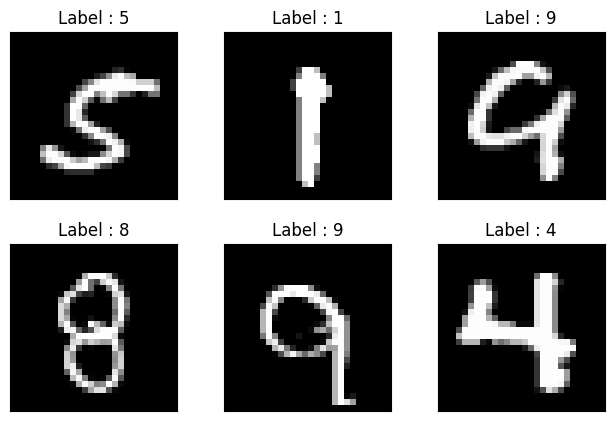

In [34]:
import matplotlib.pyplot as plt
## Affichage de quelques chiffres
ex,lab = next(iter(all_train_loader))
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(ex[i].view(WIDTH,HEIGHT), cmap='gray', interpolation='none')
  plt.title("Label : {}".format(lab[i]))
  plt.xticks([])
  plt.yticks([])
  ax = plt.gca()
  ax.set_facecolor('white')


##  A.3. <span class="alert-success"> Exercice : Classification multi-labels, nombre de couche de couches, fonction de coût </span>

L'objectif est de classer chaque image parmi les 10 chiffres qu'ils représentent. Le réseau aura donc 10 sorties, une par classe, chacune représentant la probabilité d'appartenance à chaque classe. Pour garantir une distribution de probabilité en sortie, il faut utiliser le module <a href=https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html> **Softmax** </a> : $$Sotfmax(\mathbf{x}) = \frac{\exp{x_i}}{\sum_{i=1^d} x_i}$$ qui permet de normaliser le vecteur de sortie.

* Faites quelques exemples de réseau à 1, 2, 3 couches et en faisant varier les nombre de neurones par couche. Utilisez un coût moindre carré dans un premier temps. Pour superviser ce coût, on doit construire le vecteur one-hot correspondant à la classe : un vecteur qui ne contient que des 0 sauf à l'index de la classe qui contient un 1 (utilisez ```torch.nn.functional.one_hot```).  Comparez les courbes de coût et d'erreurs en apprentissage et en test selon l'architecture.
* Le coût privilégié en multi-classe est la *cross-entropy**. Ce coût représente la négative log-vraisemblance : $$NNL(y,\mathbf{x}) = -x_{y}$$ en notant $y$ l'indice de la classe et $\mathbf{x}$ le vecteur de log-probabilité inféré. On peut utiliser soit son implémentation par le module <a href=https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss>**NLLLoss**</a>, soit - plus pratique - le module <a href=https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html>**CrossEntropyLoss** <a>  qui combine un *logSoftmax* et la cross entropie, ce qui évite d'avoir à ajouter un module de *Softmax* en sortie du réseau. Utilisez ce dernier coût et observez les changements.
* Changez la fonction d'activation en une ReLU et observez l'effet.

In [35]:
from torch import nn
from tqdm import tqdm

## On utilise qu'une partie du training test pour mettre en évidence le sur-apprentissage
TRAIN_RATIO = 0.01
train_length = int(len(train_set)*TRAIN_RATIO)
ds_train, ds_test = random_split(train_set, (train_length, len(train_set)- train_length))

#On utilise un DataLoader pour faciliter les manipulations, on fixe  la taille du mini batch à 300
train_loader = DataLoader(ds_train,batch_size=300,shuffle=True)
test_loader = DataLoader(ds_test,batch_size=300,shuffle=False)


def accuracy(yhat,y):
    # si  y encode les indexes
    if len(y.shape)==1 or y.size(1)==1:
        return (torch.argmax(yhat,1).view(y.size(0),-1)== y.view(-1,1)).float().mean()
    # si y est encodé en onehot
    return (torch.argmax(yhat,1).view(-1) == torch.argmax(y,1).view(-1)).float().mean()


In [36]:
# DIGRESSION : mini tuto sur les fonctions lambda

# 1. Construire la fonction 2 x^2 + 4
monpoly = lambda x : 2 * x**2 + 4

# 2. Utiliser la fonction
x = [1., 2., 3.]
print([(i, monpoly(i)) for i in x])


[(1.0, 6.0), (2.0, 12.0), (3.0, 22.0)]


In [22]:
# 3. Autre exemple pour transformer un entier en vecteur one-hot de dimension 3
from torch.nn.functional import one_hot

to_one_hot = lambda x: one_hot(x,3).float()

# on est dans torch => il faut donner des structures torch
print(to_one_hot(torch.tensor(0)))
print(to_one_hot(torch.tensor(1)))
try:
    print(to_one_hot(2))
except Exception as e:
    print(f"Une erreur s'est produite : {e}")



tensor([1., 0., 0.])
tensor([0., 1., 0.])
Une erreur s'est produite : one_hot(): argument 'input' (position 1) must be Tensor, not int


In [37]:

# On construit un réseau générique, où le nombre de couche pourra varier
# 10 sorties pour chaque réseau, une par classe. 
# DANS la boucle d'apprentissage:
#   SOL 1: cross entropy loss, 10 sorties, on ne rescale pas les sorties <=> GT = int
#          (la cross entropy combine un softmax + NLLloss)
#   SOL 2: MSE, 10 sorties + softmax <=> GT = 10 floats 0./1.

# Etape 1: Réseau générique

class LinearMultiClass(nn.Module):
    def __init__(self,in_features,out_features,dims=[16],activation=nn.Tanh):
        super().__init__()
        # liste des couches
        layers = []
        # Remplir la liste avec les bons modules, à la bonne taille, dans l'ordre
        ##  TODO 
        self.layers = nn.Sequential(*layers) # astuce pour créer le réseau à partir de la liste!

    def forward(self,input):
        return self.layers(input)
        
# Boucle typique pour l'entraînement
def run(model,epochs,loss_type="MSE"):
    writer = SummaryWriter(f"/tmp/logs/{model.name}-{loss_type}")
    optim = torch.optim.Adam(model.parameters(),lr=1e-3) # gradient le plus classique/robuste
    model = model.to(device)
    
    print(f"running {model.name}--{loss_type}")

    # SI loss_type == MSE
    #   - definition de la loss : MSELoss
    #   - transformation des sorties du réseau : transf_out = softmax 
    #   - transformation des étiquettes : transf_lab = one_hot + passage en float
    # SINON
    #   - definition de la loss : CrossEntropyLoss
    #   - transfos = identité

    ##  TODO 

    for epoch in tqdm(range(epochs)):
        cumloss, cumacc, count = 0, 0, 0
        for x,y in train_loader:
            optim.zero_grad()
            x,y = x.view(x.size(0),-1).to(device), transf_lab(y).to(device) # usage des fonctions def ci-dessus
            yhat = transf_out(model(x)) # usage des fonctions def ci-dessus
            l = loss(yhat,y) # usage des fonctions def ci-dessus
            l.backward()
            optim.step()
            cumloss += l*len(x)
            cumacc += accuracy(yhat,y)*len(x)
            count += len(x)
        writer.add_scalar(f'loss{loss_type}/train',cumloss/count,epoch)
        writer.add_scalar('accuracy/train',cumacc/count,epoch)
        if epoch % 50 == 0:
            with torch.no_grad():
                cumloss, cumacc, count = 0, 0, 0
                for x,y in test_loader:
                    x,y = x.view(x.size(0),-1).to(device), transf_lab(y).to(device)
                    yhat = transf_out(model(x))
                    cumloss += loss(yhat,y)*len(x)
                    cumacc += accuracy(yhat,y)*len(x)
                    count += len(x)
                writer.add_scalar(f'loss{loss_type}/test',cumloss/count,epoch)
                writer.add_scalar('accuracy/test',cumacc/count,epoch)
                    


In [38]:
# on va tester 12 réseaux = 2 loss x 3 profondeurs x 2 nb de neurones cachés
# on choisira une activation de type RELU

# si vous êtes allé au bout de l'entrainement
path = Path("./model")
path.mkdir(parents=True, exist_ok=True)

for l in ["MSE","CEL"]:
    for nb_couches in [1,2,3]:
        for nb_dim in [16,64]:

            # Créer l'instance de réseau avec les bons paramètres
            ##  TODO 
            net.name = f"net-{nb_dim}-{nb_couches}"+time.asctime()
            run(net,2000,l)

            # ramener le réseau en mémoire avant la sauvegarde
            fichier = path/f"{net.name}"
            save_model(net.to("cpu"),fichier)



OSError: [WinError 123] La syntaxe du nom de fichier, de répertoire ou de volume est incorrecte: '/tmp/logs/net-16-1Wed Oct 22 09:22:47 2025-MSE'

## D.4.  <span class="alert-success"> Exercice : Régularisation des réseaux </span>


### Pénalisation des couches
Une première technique pour éviter le sur-apprentissage est de régulariser chaque couche par une pénalisation sur les poids, i.e. de favoriser des poids faibles. On parle de pénalisation L1 lorsque la pénalité est de la forme $\|W\|_1$ et L2 lorsque la norme L2 est utilisée : $\|W\|_2^2$. En pratique, cela consiste à rajouter à la fonction de coût globale du réseau un terme en $\lambda Pen(W)$ pour les paramètres de chaque couche que l'on veut régulariser (cf code ci-dessous).

Expérimentez avec une norme L2 dans $\{0,10^{-5},10^{-4},10^{-3},10^{-2},\}$, observez les histogrammes de la distribution des poids et l'évolution de la pénalisation et du coût en fonction du nombre d'époques. Utilisez pour cela  un réseau à 3 couches chacune de taille 100 et un coût de CrossEntropy.


In [ ]:

def run_l2(model,epochs,l2_coef):
    writer = SummaryWriter(f"/tmp/logs/l2-{l2_coef}-{model.name}")
    optim = torch.optim.Adam(model.parameters(),lr=1e-3)
    model = model.to(device)
    print(f"running {model.name}-{l2_coef}")
    loss = nn.CrossEntropyLoss()
    for epoch in tqdm(range(epochs)):
        cumloss, cumacc, count = 0, 0, 0
        for x,y in train_loader:
            optim.zero_grad()
            x,y = x.view(x.size(0),-1).to(device), y.to(device)
            yhat = model(x)
            l = loss(yhat,y)

            # Ajout d'une pénalisation L2 sur toutes les couches
            l2_loss = 0.
            for name, value in model.named_parameters():
                if name.endswith(".weight"):
                    l2_loss += (value ** 2).sum()
            l += l2_coef*l2_loss
            l.backward()
            optim.step()
            cumloss += l*len(x)
            cumacc += accuracy(yhat,y)*len(x)
            count += len(x)
            
        writer.add_scalar('loss/train',cumloss/count,epoch)
        writer.add_scalar('accuracy/train',cumacc/count,epoch)
        writer.add_scalar('loss/l2',l2_loss,epoch)
        if epoch % 50 == 0:
            with torch.no_grad():
                cumloss, cumacc, count = 0, 0, 0
                for x,y in test_loader:
                    x,y = x.view(x.size(0),-1).to(device), y.to(device)
                    yhat = model(x)
                    cumloss += loss(yhat,y)*len(x)
                    cumacc += accuracy(yhat,y)*len(x)
                    count += len(x)
                writer.add_scalar(f'loss/test',cumloss/count,epoch)
                writer.add_scalar('accuracy/test',cumacc/count,epoch)
                ix = 0
                for module in model.layers:
                    if isinstance(module, nn.Linear):
                        writer.add_histogram(f'linear/{ix}/weight',module.weight, epoch)
                        ix += 1

##  TODO 

### Dropout

Une autre technique très utilisée est le <a href=https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html> **Dropout** </a>. L’idée du Dropout est proche du moyennage de modèle : en entraînant k modèles de manière indépendante, on réduit la variance du modèle. Entraîner k modèles présente un surcoût non négligeable, et l’intérêt du Dropout est de réduire la complexité mémoire/temps de calcul. Le Dropout consiste à chaque itération à *geler* certains neurones aléatoirement dans le réseau en fixant leur sortie à zéro. Cela a pour conséquence de rendre plus robuste le réseau.

Le comportement du réseau est donc différent en apprentissage et en inférence. Il est obligatoire d'utiliser ```model.train()``` et ```model.eval()``` pour différencier les comportements.
Testez sur quelques réseaux pour voir l'effet du dropout.

In [ ]:

def run_dropout(model,epochs):
    writer = SummaryWriter(f"/tmp/logs/{model.name}")
    optim = torch.optim.Adam(model.parameters(),lr=1e-3)
    model = model.to(device)
    print(f"running {model.name}")
    loss = nn.CrossEntropyLoss()
    for epoch in tqdm(range(epochs)):
        cumloss, cumacc, count = 0, 0, 0
        model.train()
        for x,y in train_loader:
            optim.zero_grad()
            x,y = x.view(x.size(0),-1).to(device), y.to(device)
            yhat = model(x)
            l = loss(yhat,y)
            l.backward()
            optim.step()
            cumloss += l*len(x)
            cumacc += accuracy(yhat,y)*len(x)
            count += len(x)
        writer.add_scalar('loss/train',cumloss/count,epoch)
        writer.add_scalar('accuracy/train',cumacc/count,epoch)
        if epoch % 50 == 0:
            model.eval()
            with torch.no_grad():
                cumloss, cumacc, count = 0, 0, 0
                for x,y in test_loader:
                    x,y = x.view(x.size(0),-1).to(device), y.to(device)
                    yhat = model(x)
                    cumloss += loss(yhat,y)*len(x)
                    cumacc += accuracy(yhat,y)*len(x)
                    count += len(x)
                writer.add_scalar(f'loss/test',cumloss/count,epoch)
                writer.add_scalar('accuracy/test',cumacc/count,epoch)


def get_dropout_net(in_features,out_features,dims,dropout):
    layers = []
    dim = in_features
    
    for newdim in dims:
        layers.append(nn.Linear(dim, newdim))
        dim = newdim
        if dropout>0: layers.append(nn.Dropout(dropout))
        layers.append(nn.ReLU())
        dim = newdim
    layers.append(nn.Linear(dim,out_features))
    return nn.Sequential(*layers)

##  TODO 

### BatchNorm

On sait que les données centrées réduites permettent un apprentissage plus rapide et stable d’un modèle ; bien qu’on puisse faire en sorte que les données en entrées soient centrées réduites, cela est plus délicat pour les couches internes d’un réseau de neurones. La technique de <a href=https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html> **BatchNorm**</a> consiste à ajouter une couche qui a pour but de centrer/réduire les données en utilisant une moyenne/variance glissante (en inférence) et les statistiques du batch (en
apprentissage).

Tout comme pour le dropout, il est nécessaire d'utiliser ```model.train()``` et ```model.eval()```. 
Expérimentez la batchnorm. 

In [ ]:
def get_batchnorm_net(in_features,out_features,dims):
    layers = []
    dim = in_features
    for newdim in dims:
        layers.append(nn.Linear(dim, newdim))
        dim = newdim
        layers.append(nn.BatchNorm1d(dim))
        layers.append(nn.ReLU())
        dim = newdim
    layers.append(nn.Linear(dim,out_features))
    return nn.Sequential(*layers)
##  TODO 

# Construction du sujet à partir de la correction

In [ ]:
###  TODO )"," TODO ",\
    txt, flags=re.DOTALL))
f2.close()

### </CORRECTION> ###